In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import time
from ipypb import track

import GCP_GD3 as gcp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor
from general_functions import create_filter, hr

### Zero launch of a function(for NUMBA):

In [2]:
init_shape = (100, 100, 10)
coo, vals = gen_coo_tensor(init_shape, density=0.002)
assert check_coo_tensor(coo)!= "Bad"

In [5]:
%%time

max_iter = 12
rank = 5
seed = 13

a, b, c, err, it = gcp.gcp_gd(
    coo, vals, init_shape,
    gcp.bernoulli_logit_loss,
    gcp.bernoulli_logit_loss_grad,
    rank=rank,
    lr=0.1,
    l2=0,
    max_iter=max_iter,
    tol=1e-8,
    seed=seed,
    show_iter=False,
    it_over=False,
)

rerr = sqrt_err_relative(
    coo, vals, init_shape, a, b, c,
)
print(rerr, err[-1])

0.9999628598575782 [0.69319699]
CPU times: user 5.57 ms, sys: 0 ns, total: 5.57 ms
Wall time: 5.49 ms


### Load the data:

In [6]:
path_data = "Link_Prediction_Data/FB15K237/"
entity_list = pickle.load(open(path_data + 'entity_list', 'rb'))
relation_list = pickle.load(open(path_data + 'relation_list', 'rb'))

train_triples = pickle.load(open(path_data + 'train_triples', 'rb'))
valid_triples = pickle.load(open(path_data + 'valid_triples', 'rb'))
test_triples = pickle.load(open(path_data + 'test_triples', 'rb'))
train_valid_triples = pickle.load(open(path_data + 'train_valid_triples', 'rb'))

entity_map = pickle.load(open(path_data + 'entity_map', 'rb'))
relation_map = pickle.load(open(path_data + 'relation_map', 'rb'))

all_triples = train_valid_triples + test_triples

In [7]:
test_filter = create_filter(test_triples, all_triples)  
valid_filter = create_filter(valid_triples, all_triples)  

### Create Sparse COO Train Tensor:

In [8]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.float64)

coords = np.array(train_triples, dtype=np.int32)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(14541, 237, 14541)

## GCP-GD3:

In [468]:
max_iter = 28 #1000/20/20/20/20/20/22/25/28/30                    #bernoulli_logit_loss
rank = 200 #100/200/200/200/200/200/200/200/200/250
l2 = 0 #0/0/0/0/0/0/0/0/0/0
lr = 7000 #100/4000/5000/6000/7000/7000/7000/7000/7000/6300
seed = 13 #2/2/2/2/2/13/13/13/13/13  -> 0.256/0.269/0.29/0.317/0.323/0.334/0.343/0.348/0.353/0.324

In [472]:
%%time

a, b, c, err_arr, it = gcp.gcp_gd(
    coords, values, data_shape,
    gcp.bernoulli_logit_loss, #gaussian_loss
    gcp.bernoulli_logit_loss_grad, #bernoulli_logit_loss
    rank=rank,
    lr=lr,
    l2=l2,
    max_iter=max_iter,
    tol=1e-8,
    seed=seed,
    show_iter=False,
    it_over=True,
)

iterations over
CPU times: user 29.1 s, sys: 149 ms, total: 29.2 s
Wall time: 29 s


In [473]:
rerr = sqrt_err_relative(
    coords, values, data_shape, a, b, c,
)
print(f"Relative error = {rerr}, {(np.isnan(a)).sum()}, {(np.isnan(b)).sum()}, {(np.isnan(c)).sum()}")

Relative error = 15.730806760239101, 0, 0, 0


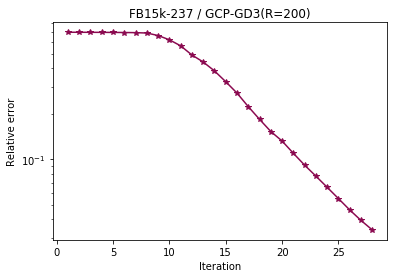

In [474]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"FB15k-237 / GCP-GD3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(1, it+1), err_arr[:it], '-*', c="#8b0a50")

In [466]:
%%time
hr(valid_filter, valid_triples, a, b, c, [1, 3, 10])

CPU times: user 3min 1s, sys: 78.7 ms, total: 3min 1s
Wall time: 3min 1s


(0.10561733675506131,
 0.21653835186769319,
 0.3443969204448246,
 0.1861689178547031)

In [467]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

CPU times: user 3min 34s, sys: 86.3 ms, total: 3min 34s
Wall time: 3min 34s


(0.1035864360402619,
 0.2116192709860256,
 0.33909899345255545,
 0.18193311188323888)